# Predicting Heart Disease Using Classification 


## Introduction 

Cardiovascular diseases (CVDs) are the leading cause of death globally, taking an estimated 17.9 million lives each year. One of the best ways to reduce the mortality and severity of heart diseases is early detection in an individual.
Our dataset is created by hospitals and institutions from three different countries (Hungarian, Cleveland, and VA). The original database(UCI Machine Learning Repository) involves the variables such as age, sex, chest pain (cp), cholesterol (chol), resting blood pressure (trestbps), maximum heart rate achieved (thalach) etc. and a final column which classifies the presence of heart disease (angiographic disease status) where 0 represents the absence of heart disease and 1-4 represents the presence of heart disease.
In this project, we seek to utilize some commonly available medical metrics -- age, maximum heart rate achieved, and cholesterol-- to predict whether an individual has heart disease or not.


## Preliminary exploratory data analysis:

Before beginning the project, we load all the required libraries and also restrict the size of our tables to make sure no particular table takes too much space. 

In [2]:
# loading all the required libraries. 
library(tidyverse) 
library(dplyr)
library(tidymodels) 
library(gridExtra)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(1)

We first examined the four possible data set for our analysis. We chose four different locations to have a better representation of the population and as different locations contribute to different results we can have a well-trained model. 
we want to have almost equal amount of data from each location in our training and testing set and avoid any unluckiness, such as training out model based on data that are mostly from two locations and testing it on the testing set that mainly includes data from the third one. Therefore, we added the location column, to use it later when spiliting our data into training and testing set.
We decided to ignore one of the sub-datasets (heart-data-2, data from switzerland) as the dataset contained numerous missing values for important columns such as cholesterol. 
The next step was renaming the columns and binding the three data sets together. 

In [3]:
#Purpose of the cell: loading the required datasets, mutating and merging them
heart_data1 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names=FALSE)
heart_data2 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names=FALSE)
heart_data3 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names=FALSE)
heart_data4 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names=FALSE)

#adding location
hungarian_data <- heart_data1 %>%
    mutate (location = "Hungarian")
cleveland_data <- heart_data3 %>%
    mutate (location = "Cleveland")
va_data <- heart_data4 %>%
    mutate (location = "Va")

#merging the data from the various cities 
heart_data <- rbind (hungarian_data, cleveland_data, va_data)
#adding column names to the data 
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs",  "restecg", "thalach", "exang",  "oldpeak", "slope",  "ca",  "thal", "num", "location")
#viewing the data
head(heart_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_double(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_d

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,location
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
28,1,2,130,132,0,2,185,0,0,?,?,?,0,Hungarian
29,1,2,120,243,0,0,160,0,0,?,?,?,0,Hungarian
29,1,2,140,?,0,0,170,0,0,?,?,?,0,Hungarian
30,0,1,170,237,0,1,170,0,0,?,?,6,0,Hungarian
31,0,2,100,219,0,1,150,0,0,?,?,?,0,Hungarian
32,0,2,105,198,0,0,165,0,0,?,?,?,0,Hungarian


We continue with tidying the data by altering the “num” from the original dataset and changing the values [0, 4] to either yes or no. In the original dataset, 0 indicates absence of heart-disease and [1,4] all represent presence of the same, just with different magnitude. As we were only concerned with the presence(or absence) of heart disease, we changed the numbers to “yes” or “no”.

We then chose our predictors with the following reasoning and based on the figures 1.1 to 2.3 visualized below.

Age - People age 65 and older are much more likely than younger people to suffer a heart attack, to have a stroke, or to develop heart disease and heart failure(“Heart Health and Aging”). This can be due to the heart not being able to beat fast enough during physical activity or times of stress as it did earlier or due to the buildup of fatty deposits in the walls of arteries over the years. It is also evident from firgure 1.1 and 2.1 that as age increases, more proportion of people have heart disease; after the dashed line, representing the mean value, the ratio of people with heart disease is higher.

Cholesterol: Increased amounts of cholesterol can build up in the wall of your arteries leading to the thinning of the arteries and ultimately leading to less blood flow to the heart muscle(“Cholesterol and Heart Disease”). This can lead to various heart diseases and even heart attacks, in some cases. Similarly, we can see in figures 1.2 and 2.2 that people with cholesterol of over 200 mg/dl are more likely to have heart disease.

Maximum Heart Rate Achieved: A higher heart rate is a good thing that leads to greater fitness(“Understanding Your Target Heart Rate”). A higher heart rate means that the heart is functioning well and is able to pump blood quickly and effectively. Lower maximum heart rate means that either the heart is unable to pump blood at higher speeds or that the person is not doing activities that allow their heart rate to reach such levels, in most cases. Figures 1.3 and 2.3 also show that people who did not get to a certain maximum heart rate, around 140, had a significantly higher chance of heart failure.

We did not use the rest of the columns because of three main reasons. Firstly, many of the variables were categorical (or binary), such as "fbs," "cp," "slope," and "thal," and as we are using the euclidean distance in the KNN classification model, we cannot be sure what values to assign to each category. For instance, "fbs" is either 0 or 1; zero represents fasting blood sugar of less than 120, and one is for more. These numbers are arbitrarily assigned and are not the best indicators of fasting blood sugar, and we cannot easily reassign numbers. Secondly, some of the columns, including "oldpeak" and "ca" are missing many values. We decided that adding one less correlated predictor is not worth giving up data on more correlated predictors such as maximum heart rate. Lastly, "oldpeak" and some of the other variables, such as "slope," are not commonly accessible, and our main goal of this project is to find an algorithm that can detect heart disease based on accessible information. 

In [4]:
#tidying the data further by modifying num column to show weather the patient has heart disease or not
num <- heart_data %>%
    select (num) %>%
    mutate (num = as.character (num))
num [num == "1"] <- "Y"
num [num == "2"] <- "Y"
num [num == "3"] <- "Y"
num [num == "4"] <- "Y"
num [num == "0"] <- "N"
num <- num %>%
 mutate (num = as_factor (num))

# Selecting the predictors 
heart_data_selected <- heart_data%>%
    select (age, chol, thalach, location)
#merging the data again 
heart_data_merged <- cbind(heart_data_selected, num) %>%
    rename ("heart_disease" = "num")
#changing the data types of some columns 
heart_data_final <- heart_data_merged %>%
     mutate (chol = as.numeric (chol),
            thalach = as.numeric (thalach))           
head(heart_data_final)

heart_data_final

Warning message:
“Problem with `mutate()` input `chol`.
ℹ NAs introduced by coercion
ℹ Input `chol` is `as.numeric(chol)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thalach`.
ℹ NAs introduced by coercion
ℹ Input `thalach` is `as.numeric(thalach)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


,age,chol,thalach,location,heart_disease
,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,28,132,185,Hungarian,N
2,29,243,160,Hungarian,N
3,29,NA,170,Hungarian,N
4,30,237,170,Hungarian,N
5,31,219,150,Hungarian,N
6,32,198,165,Hungarian,N


age,chol,thalach,location,heart_disease
<dbl>,<dbl>,<dbl>,<chr>,<fct>
28,132,185,Hungarian,N
29,243,160,Hungarian,N
29,NA,170,Hungarian,N
⋮,⋮,⋮,⋮,⋮
55,223,100,Va,Y
58,385,NA,Va,N
62,254,93,Va,Y


As talked about earlier, to make sure the data is represented(based on their location) proportionally in both the training and testing data. We split the data into different data sets based on the location column that we added earlier. Then, the location specific data was split into testing and training data. Now, we have location specific training and testing data which can be merged together to make up our final testing and training data. 
Before proceeding with the splitting, we set the seed to ensure the reproducibility of the data as the process of splitting the data into training and testing involves randomness. 

In [5]:
# seperating the data into different data set based on their location
set.seed(1)

#Omitting the NAs and unnecessary 0s (some data sets put 0 instead of NA) in our data to aid in classification
   
hungarian_data_cleaned <- heart_data_final %>%
    filter (location == "Hungarian") %>%
    na.omit () %>%
    filter (chol != 0)

cleveland_data_cleaned <- heart_data_final %>%
    filter (location == "Cleveland") %>%
    na.omit () %>%
    filter (chol != 0)

va_data_cleaned <- heart_data_final %>%
    filter (location == "Va") %>%
    na.omit () %>%
    filter (chol != 0)

# spliting the data into training and testing for each of those locations

heart_data_split_hung <- initial_split(hungarian_data_cleaned, prop=.75, strata = heart_disease)
heart_data_training_hung <- training(heart_data_split_hung) 
heart_data_testing_hung <- testing(heart_data_split_hung)

heart_data_split_clev <- initial_split(cleveland_data_cleaned, prop=.75, strata = heart_disease)
heart_data_training_clev <- training(heart_data_split_clev) 
heart_data_testing_clev <- testing(heart_data_split_clev)

heart_data_split_va <- initial_split(va_data_cleaned, prop=.75, strata = heart_disease)
heart_data_training_va <- training(heart_data_split_va) 
heart_data_testing_va <- testing(heart_data_split_va)

#putting all of the training-set together
heart_data_training <- rbind (heart_data_training_hung, heart_data_training_clev, heart_data_training_va)

#putting all of the testing-set together
heart_data_testing <- rbind (heart_data_testing_hung, heart_data_testing_clev, heart_data_testing_va)



Now, we move on to summarising the data. Firstly, we calculated the mean of the three predictors: age, chol, thalach (maximum heart rate). After calculating the mean, we presented it in the form of a table that has been tidied using the pivot longer function to aid in readability. Secondly, we calculated the number of NAs in each of the columns to get an idea of the missing values in our dataset. Lastly, we ascertained the proportion of people with heart disease in our final dataset and proportion of people without heart disease. 

In [6]:
#Goal of the cell: summarizing the data 

heart_data_cleaned_final <- heart_data_final %>%
    select (- location)

#calculating the mean 
predictors_mean <- heart_data_training %>%
    summarize(across (age:thalach, mean, na.rm = TRUE))

#using pivot_longer to show the mean value of each column in a table
predictors_mean_final <- pivot_longer(predictors_mean, 
                               cols = age:thalach, 
                               names_to = "predictors",
                              values_to = "mean")

#counting the missing data 
na_count <- map_df(heart_data_cleaned_final, ~sum(is.na(.)))
#using pivot_longer to show the number of NAs in a table
na_count_final <- pivot_longer(na_count,
                               cols = age:heart_disease,
                               names_to = "predictors",
                               values_to = "number_of_nas")


#Proportion of heart disease 
heart_disease_proportion <- heart_data_training %>%
    group_by (heart_disease) %>%
    summarize (observation_number = n()) %>%
    mutate (percent = 100*observation_number/nrow(heart_data_training))  

`summarise()` ungrouping output (override with `.groups` argument)



In [7]:
predictors_mean_final

predictors,mean
<chr>,<dbl>
age,52.27308
chol,244.27898
thalach,141.14342


##### Table 1: Calculating the mean of all the predictors used in the analysis 

In [8]:
na_count_final

predictors,number_of_nas
<chr>,<int>
age,0
chol,30
thalach,54
heart_disease,0


##### Table 2: Calculating the number of rows with missing data in each of the columns

In [9]:
heart_disease_proportion

heart_disease,observation_number,percent
<fct>,<int>,<dbl>
N,268,52.65226
Y,241,47.34774


##### Table 3: Calculating the proportion of "yes" and "no" within the target variable: the "heart disease" column 

We use ggpairs to see the overall relations between the variables and the target variable.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



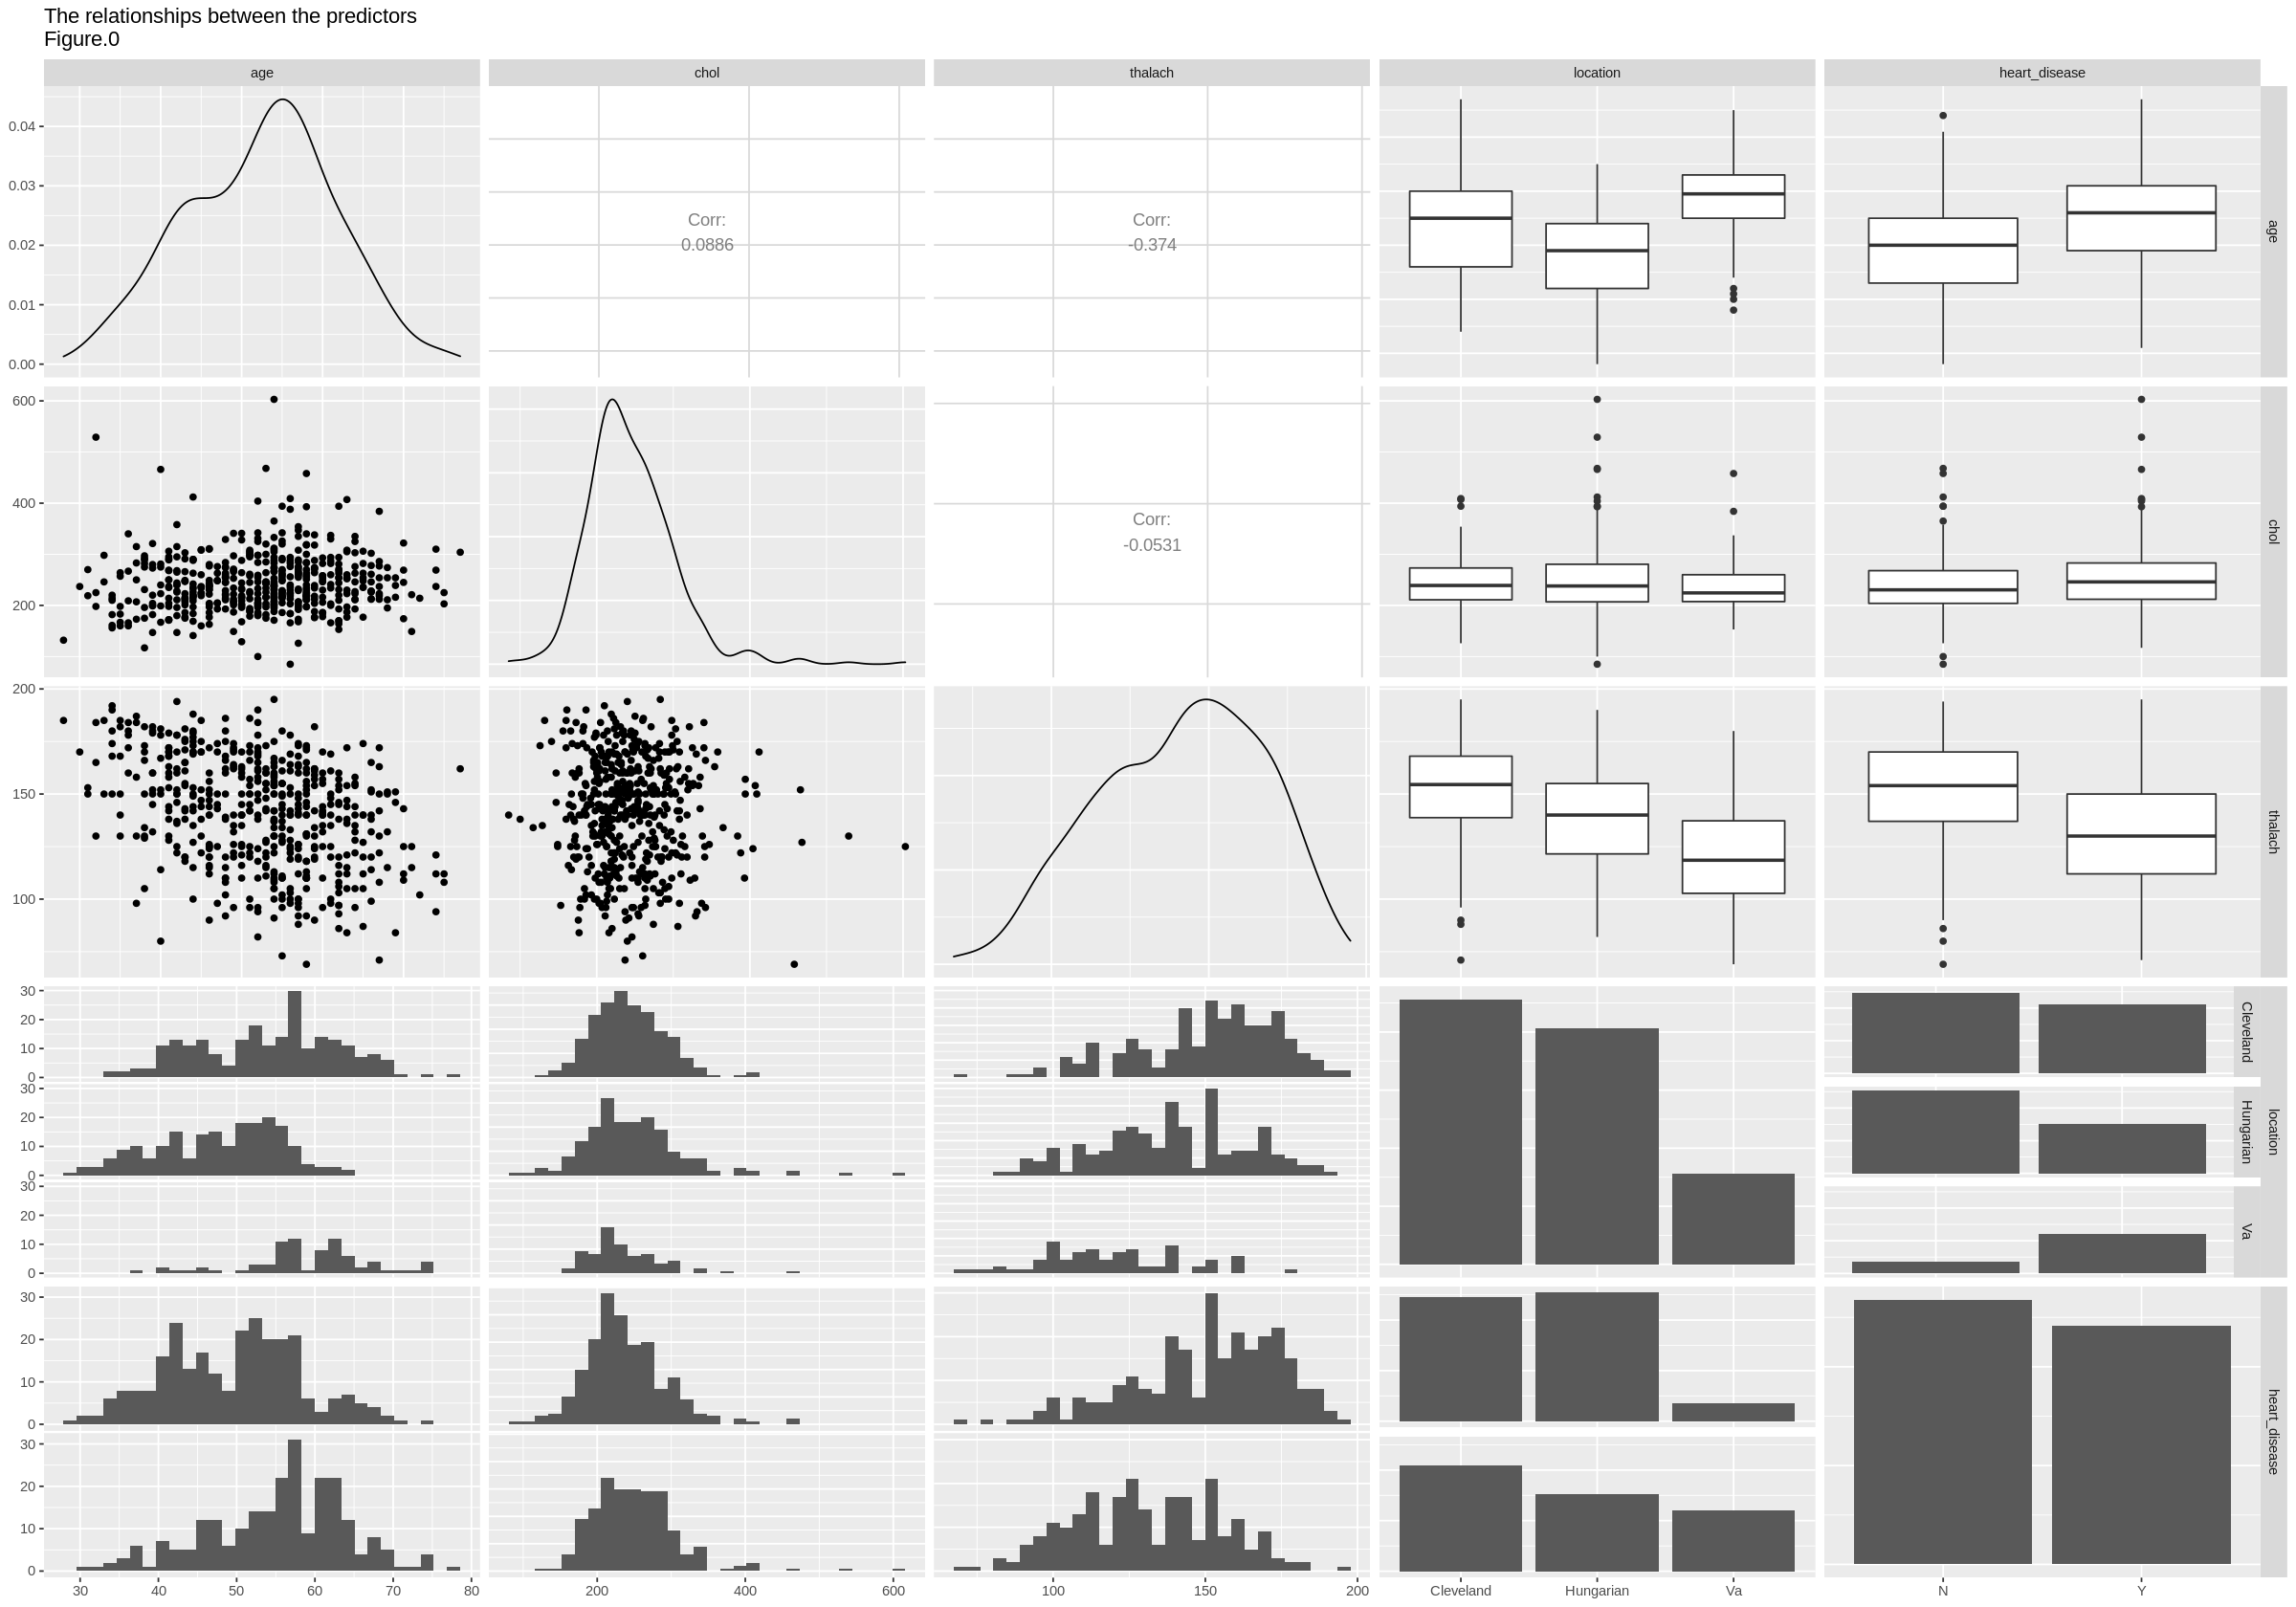

In [10]:
options(repr.plot.height = 14, repr.plot.width=20)
heart_ggpair <- heart_data_training %>% 
    ggpairs()+
    ggtitle ("The relationships between the predictors
Figure.0") 
    
heart_ggpair

As can be seen, the result is not the most effective visualization as the target variable is categorical; therefore, we used scatterplot and histograms to better illustrate the relations and use them to aid in choosing the predictors. Firstly, we visualize the data using scatterplots where we plotted 2 of the three predictors on the axes. Also, the points were coloured based on whether they represented "yes" or "no" in the heart disease column. This allowed us to gain some insight which was used to select the predictor variables. After the scatterplot, we used histograms to display the distribution of the predictors. Again, we colour-coded the histogram to represent the 'yes' or 'no' under the heart disease column. This reinforced the insight that we got from the earlier scatterplots. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



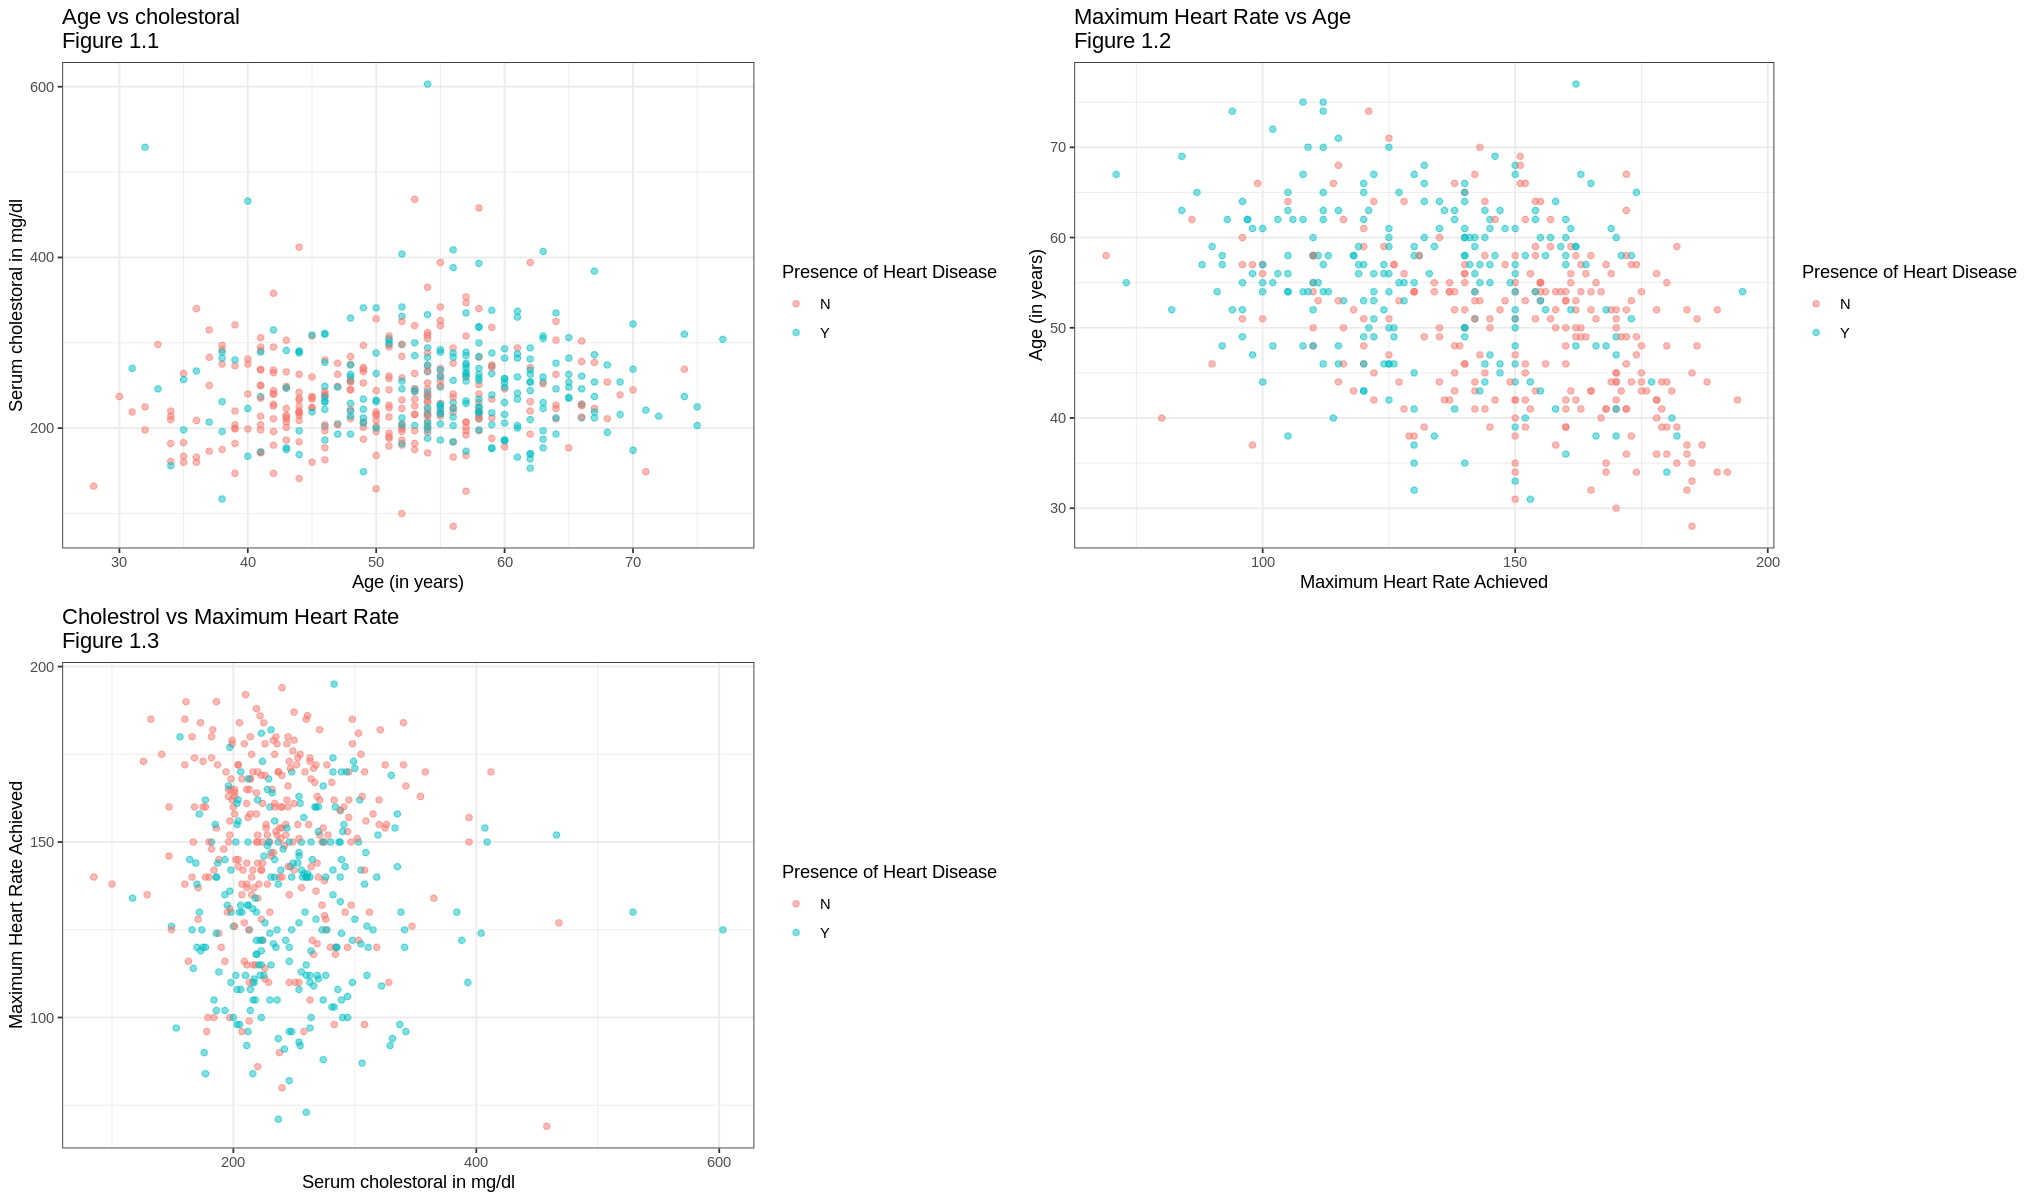

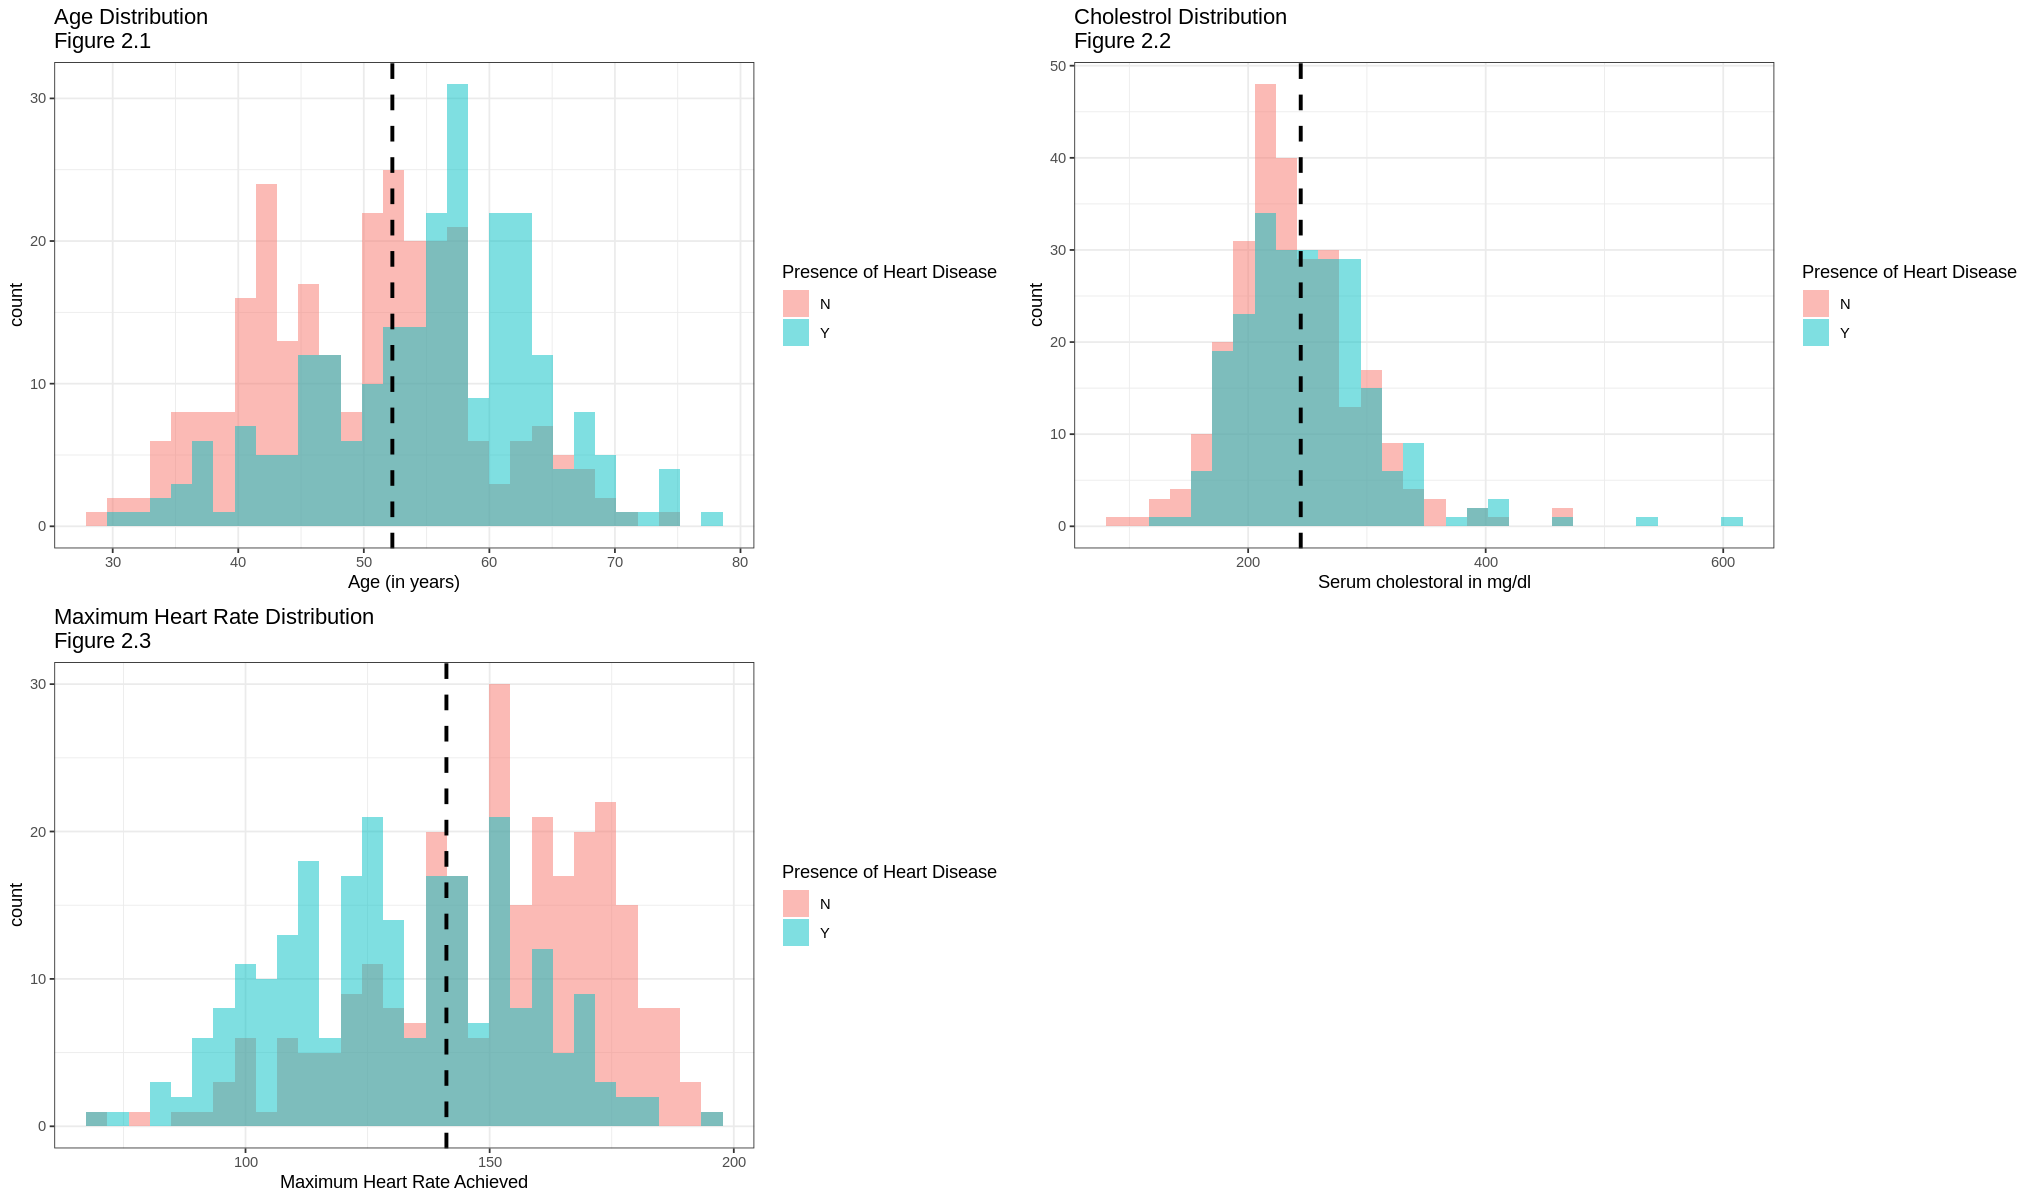

In [11]:
#visualising the data 


#changing the plot size 
options(repr.plot.height = 10, repr.plot.width=17)

# part 1: geom-points

age_chol <- heart_data_training %>% 
filter (chol != 0) %>%
ggplot(aes(x = age, y = chol, color = heart_disease)) + 
geom_point(stat = "identity", alpha = 0.5)+ 
labs(x="Age (in years)", y = "Serum cholestoral in mg/dl", color = "Presence of Heart Disease")+
theme (text = element_text (size = 15))+
ggtitle("Age vs cholestoral
Figure 1.1")+
theme_bw()

thalach_age <- heart_data_training %>% 
ggplot(aes(x = thalach, y = age, color = heart_disease)) + 
geom_point(stat = "identity", alpha = 0.5)+
labs(x = "Maximum Heart Rate Achieved", y= "Age (in years)", color = "Presence of Heart Disease")+
theme (text = element_text (size = 15))+
ggtitle("Maximum Heart Rate vs Age
Figure 1.2")+
theme_bw()

chol_thalach <- heart_data_training %>% 
filter (chol != 0) %>%
ggplot(aes(x = chol, y = thalach , color = heart_disease)) + 
geom_point(stat = "identity", alpha = 0.5)+
labs(x = "Serum cholestoral in mg/dl" , y= "Maximum Heart Rate Achieved", color = "Presence of Heart Disease")+
theme (text = element_text (size = 15))+
ggtitle("Cholestrol vs Maximum Heart Rate 
Figure 1.3")+
theme_bw()

grid.arrange(age_chol, thalach_age, chol_thalach, nrow=2)

# part 2: histograms
age_plot <- heart_data_training %>% 
ggplot(aes(x = age, fill = as_factor(heart_disease))) + 
geom_histogram(alpha=0.5, position = "identity") + 
geom_vline(xintercept = 52.27308, linetype="dashed", size = 1.1)+
labs(x="Age (in years)", fill = "Presence of Heart Disease")+
theme (text = element_text (size = 15))+
ggtitle("Age Distribution
Figure 2.1")+
theme_bw()

chol_plot <- heart_data_training %>% 
    filter (chol != 0) %>%
ggplot(aes(x = chol, fill = as_factor(heart_disease))) + 
geom_histogram(alpha=0.5, position = "identity") + 
geom_vline(xintercept = 244.27898, linetype="dashed", size = 1.1)+
labs(x="Serum cholestoral in mg/dl", fill = "Presence of Heart Disease")+
theme (text = element_text (size = 15))+
ggtitle("Cholestrol Distribution
Figure 2.2")+
theme_bw()

thalach_plot <- heart_data_training %>% 
ggplot(aes(x = thalach, fill = as_factor(heart_disease))) + 
geom_histogram(alpha=0.5, position = "identity") +
geom_vline(xintercept = 141.14342, linetype="dashed", size = 1.1)+
labs(x = "Maximum Heart Rate Achieved", fill = "Presence of Heart Disease")+
theme (text = element_text (size = 15))+
ggtitle("Maximum Heart Rate Distribution
Figure 2.3")+ 
theme_bw()

grid.arrange(age_plot, chol_plot, thalach_plot, nrow=2)


# Side notes:
# the added dashed lines for histograms represents the mean value of each predictor
# the 0 cholestrols are filtered for the purpose of better visualization

After the visualization, we moved on to the actual classification part of the project. Firstly, we created a recipe where we specified the predictor variables for the data along with standardizing the data as KNN classification relies on calculating the euclidean distance. Then, we created the spec where we specified the engine, the mode, and the formula that will be used to calculate the distance. 

In [12]:
#make a recipe
set.seed(1)


heart_recipe <- recipe (heart_disease ~  age + chol + thalach , heart_data_training) %>%
    step_scale (all_predictors()) %>%
    step_center (all_predictors()) 
heart_recipe

heart_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) %>%
    set_engine ("kknn") %>%
    set_mode ("classification")
heart_spec


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, we created a tibble with various K values and created a vfold so that we can do cross validation. This was done to determine the best value of k, which would give us the highest accuracy. Cross validation is done to make sure our accuracy is not affected too much by data that ends in the training and the validation data set. We chose to iterate over values of k between 1 and 25  because of two main reasons. Firstly, our training data set has about 500 data points and choosing numbers greater than 25 increases the chance of underfitting (as we would be checking a relatively large chunk of our data each time). Secondly, having more than 25 neighbours to check for each new observation is very expensive and time-consuming. Therefore, although the accuracy does not drop significantly after 25 neighbours, as can be seen in figure 3.1, considering the cost as well as the chance of underfitting, we decided to iterate over values less than 25.  
Lastly, we combine it all into a workflow where the recipe and the spec are specified. We then collect the metrics(accuracy) and then plot it to show the accuracy associated with the respective value of K.

In [13]:
set.seed(1)
# In our experiments, we observed that after 25 adding more neigbors does not change the accuracy much 
# Therefore, for the mentioned reasons we make a tibble from 1 to 25
k_table <- tibble (neighbors = seq (1, 25))

heart_vfold <- vfold_cv (heart_data_training, v = 5, strata= heart_disease)

heart_workflow <- workflow()%>%
    add_recipe (heart_recipe) %>%
    add_model (heart_spec) %>%
    tune_grid (resamples = heart_vfold, grid = k_table) %>%
    collect_metrics () %>%
    filter (.metric == "accuracy")   

heart_max_k <- heart_workflow %>%
    select (mean, neighbors) %>%
    arrange (desc (mean)) %>%
    slice (1) 

heart_vs_k_plot <- ggplot (heart_workflow, aes (x = neighbors, y = mean)) + 
        geom_point () +
        geom_line () +
        labs (x = "Neighbors", y = "accuracy")+
        ggtitle("The accuracy associated with k values
Figure 3.1") +
        theme (text = element_text (size = 20))+
        theme_bw()



In [14]:
heart_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5973995,5,0.03581579,Model01
2,accuracy,binary,0.5973995,5,0.03581579,Model02
3,accuracy,binary,0.6543623,5,0.03244020,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,binary,0.6937535,5,0.01862117,Model23
24,accuracy,binary,0.6937535,5,0.01862117,Model24
25,accuracy,binary,0.6838335,5,0.01409851,Model25


##### Table 4: Determining the accuracy of the model at various values of K 

In [15]:
heart_max_k

mean,neighbors
<dbl>,<int>
0.6937535,23


##### Table 5: Determining the Best Value of K 

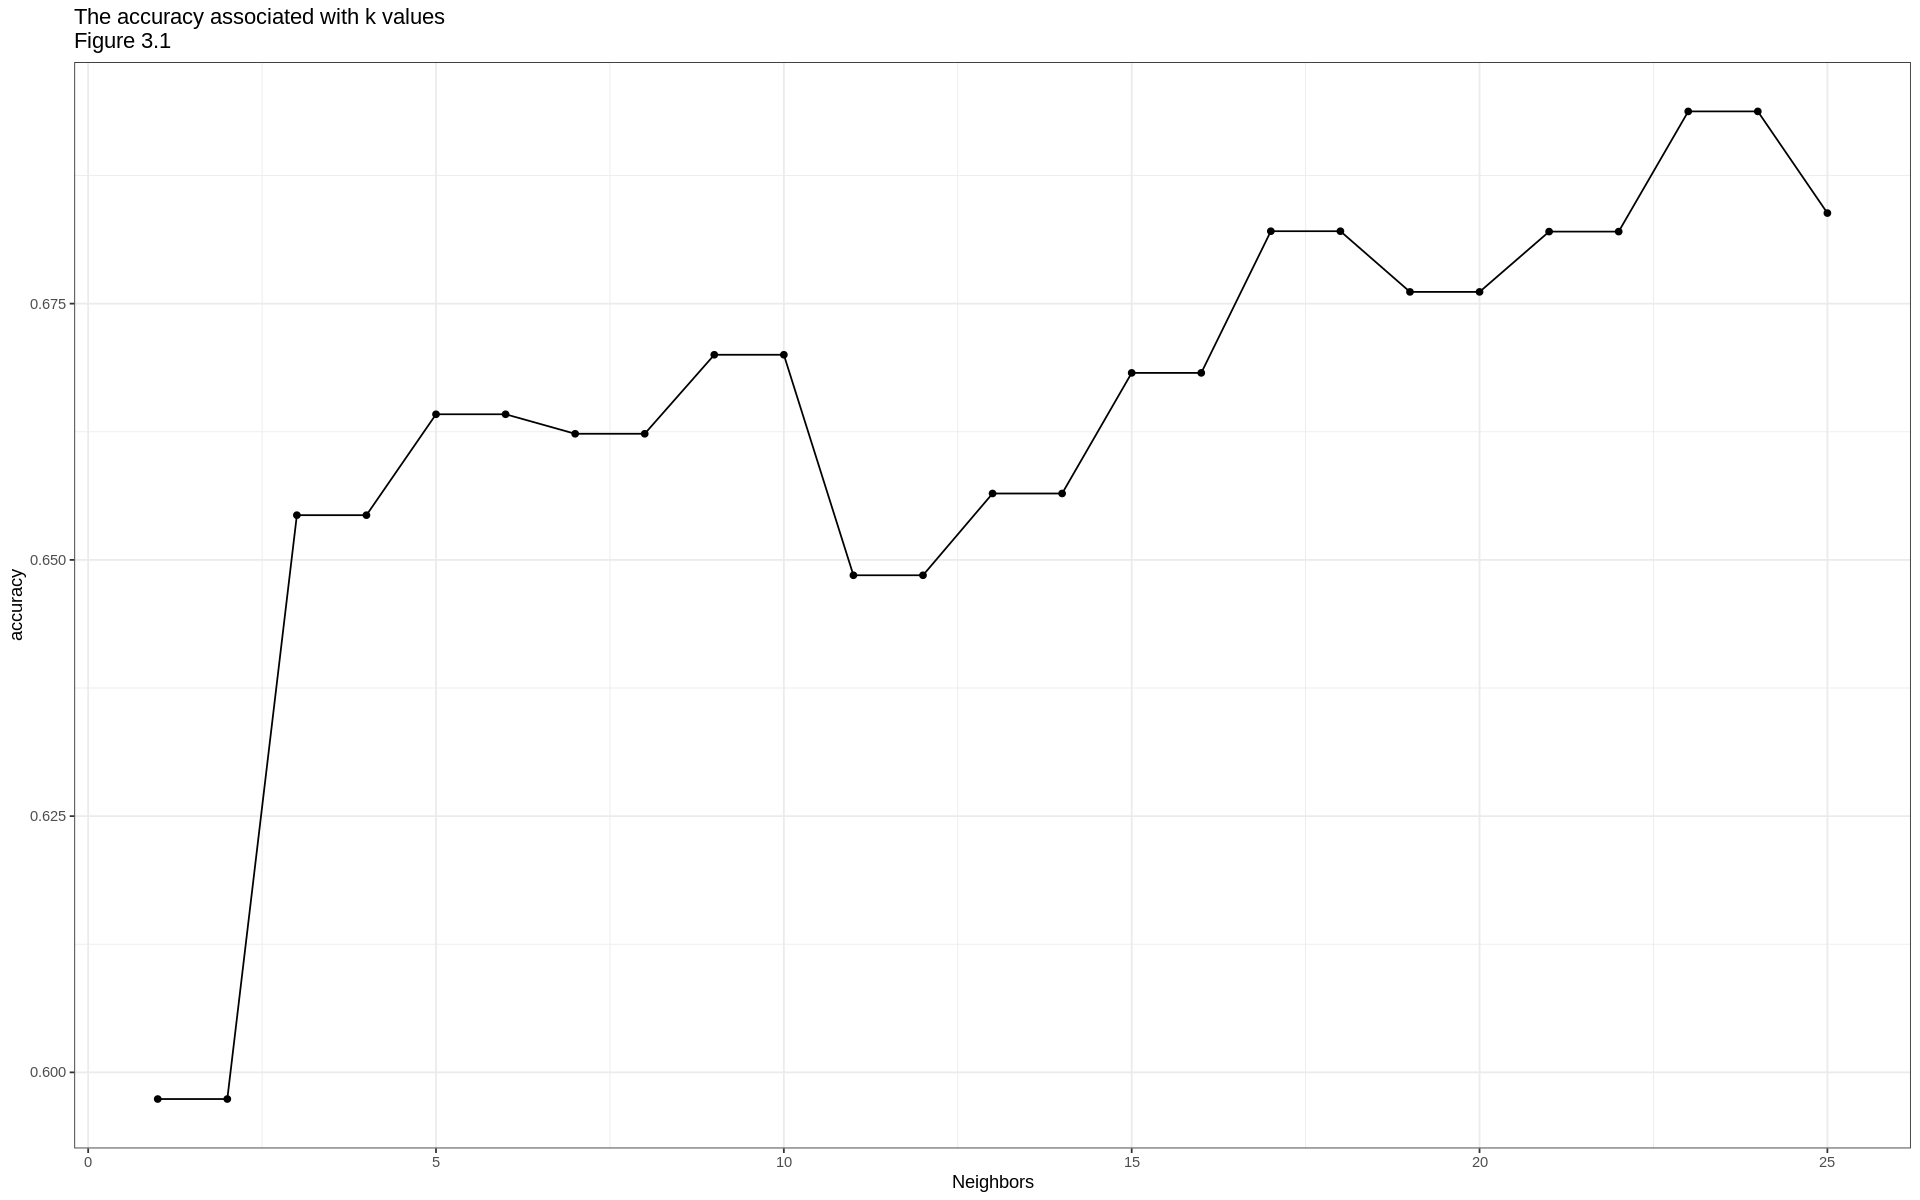

In [16]:
options(repr.plot.height = 10, repr.plot.width=16)
heart_vs_k_plot

Lastly, we used the k value with the highest accuracy to train our whole training set. (k = 23 had the highest accuracy of 69%)

Next, we used the training model to predict on the testing set. We used the prediction values and the actual observed value to estimate our accuracy, about 66%. Finally, we made a confusion matrix to separately examine how accurate our model predicts "yes" and "no" values for heart disease.

In [17]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) %>%
    set_engine("kknn")%>%
    set_mode("classification")

knn_fit <- workflow()%>%
    add_recipe(heart_recipe)%>%
    add_model(knn_spec) %>%
    fit(data = heart_data_training)

heart_test_predictions <- predict(knn_fit, heart_data_testing) %>%
  bind_cols(heart_data_testing)


heart_test_predictions_estimates <- heart_test_predictions %>%
  metrics(truth = heart_disease, estimate = .pred_class)%>%
  filter(.metric == "accuracy")


confusion_metric <- heart_test_predictions %>%
    conf_mat(truth = heart_disease, estimate = .pred_class)

In [18]:
heart_test_predictions_estimates

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6586826


##### Table 6: Accuracy of the model on the testing set.

In [19]:
confusion_metric

          Truth
Prediction  N  Y
         N 56 25
         Y 32 54

##### Table 7: Confusion Matrix

To visualise the results of our classification, we plotted the testing data coloured with the true values of heart disease on one hand and on the other hand, we plotted the scatterplot but coloured it on the basis of the predictions made by our model. This serves a twofold purpose: 
1. It allows us to judge the accuracy(or inaccuracy) as we can see the side by side what points were predicted incorrectly by our model. 
2. Moreover, we can also see how certain predictor variables are influencing the prediction of our model.  For example, in figure 5.1, we can clearly see that as age increases, our model is much more likely to predict "yes" to heart disease. 

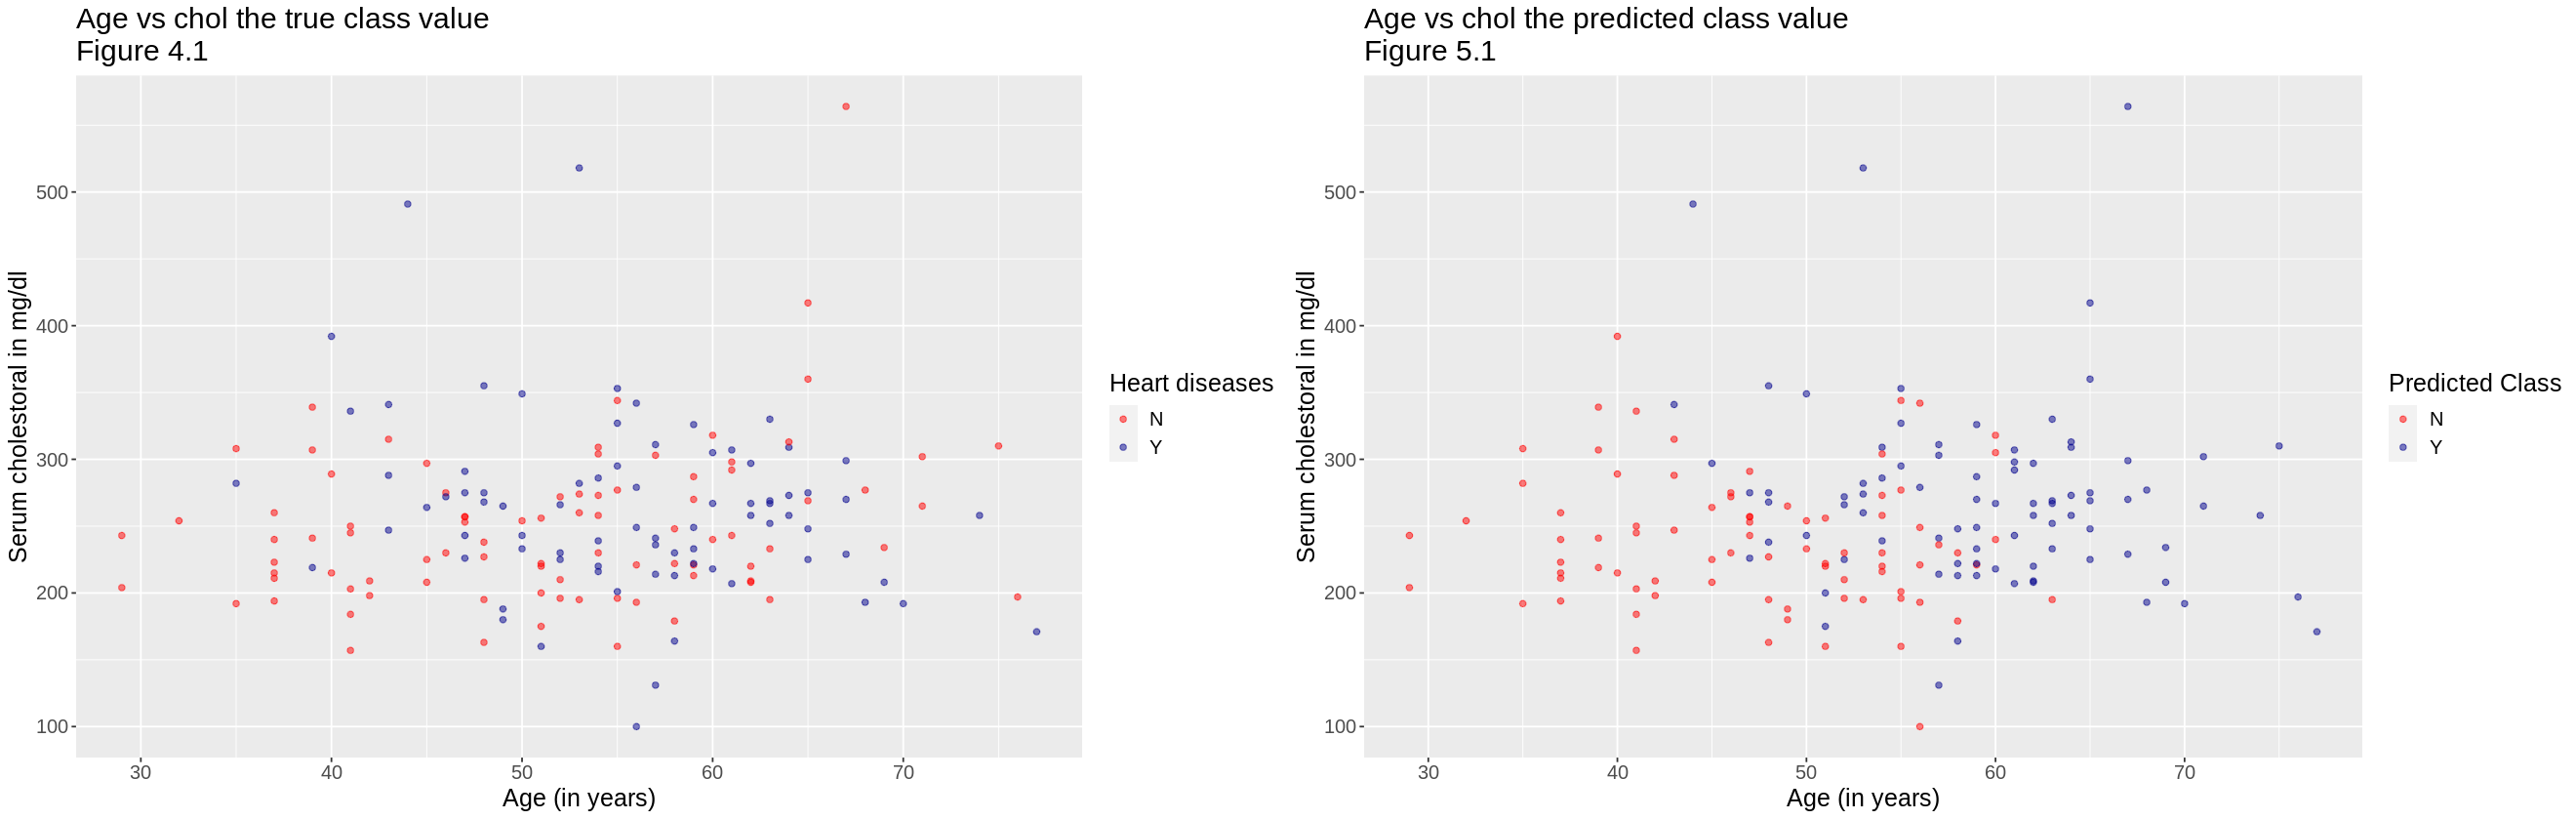

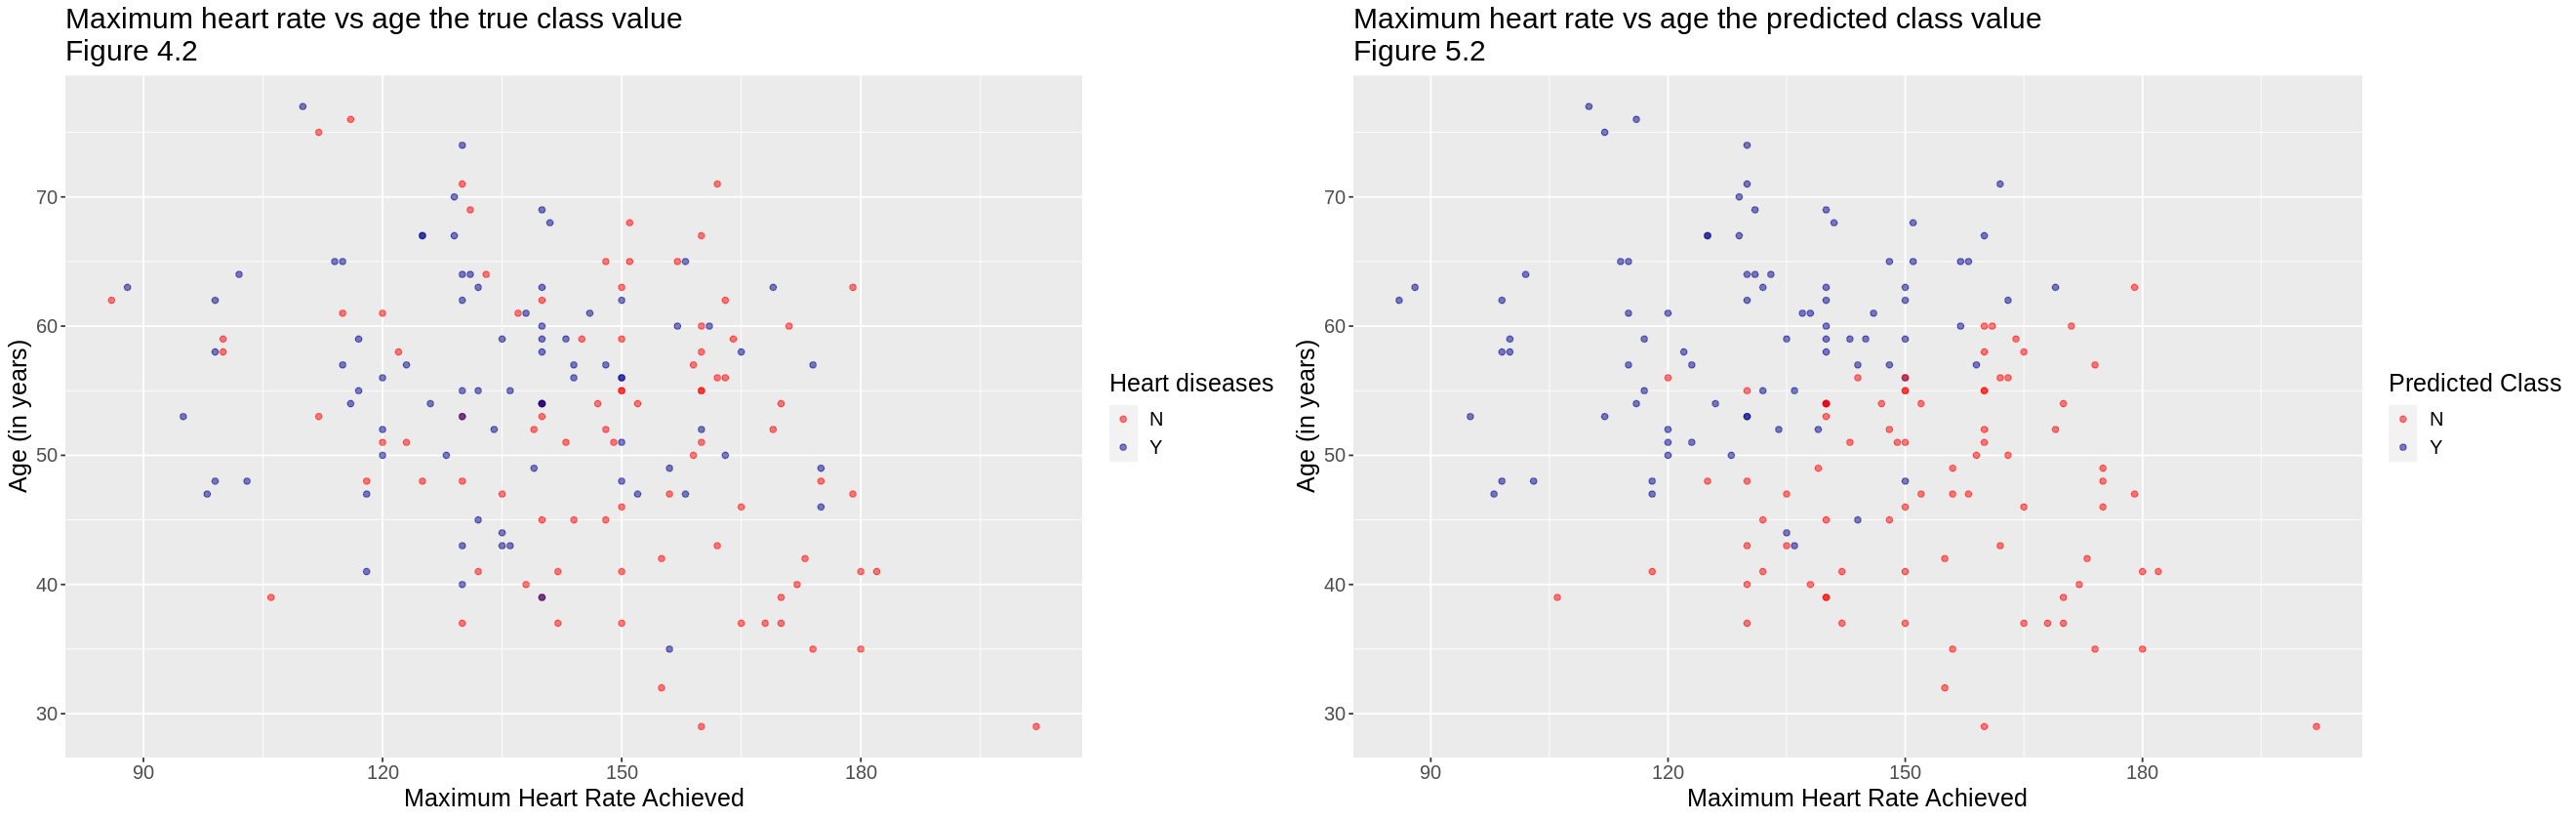

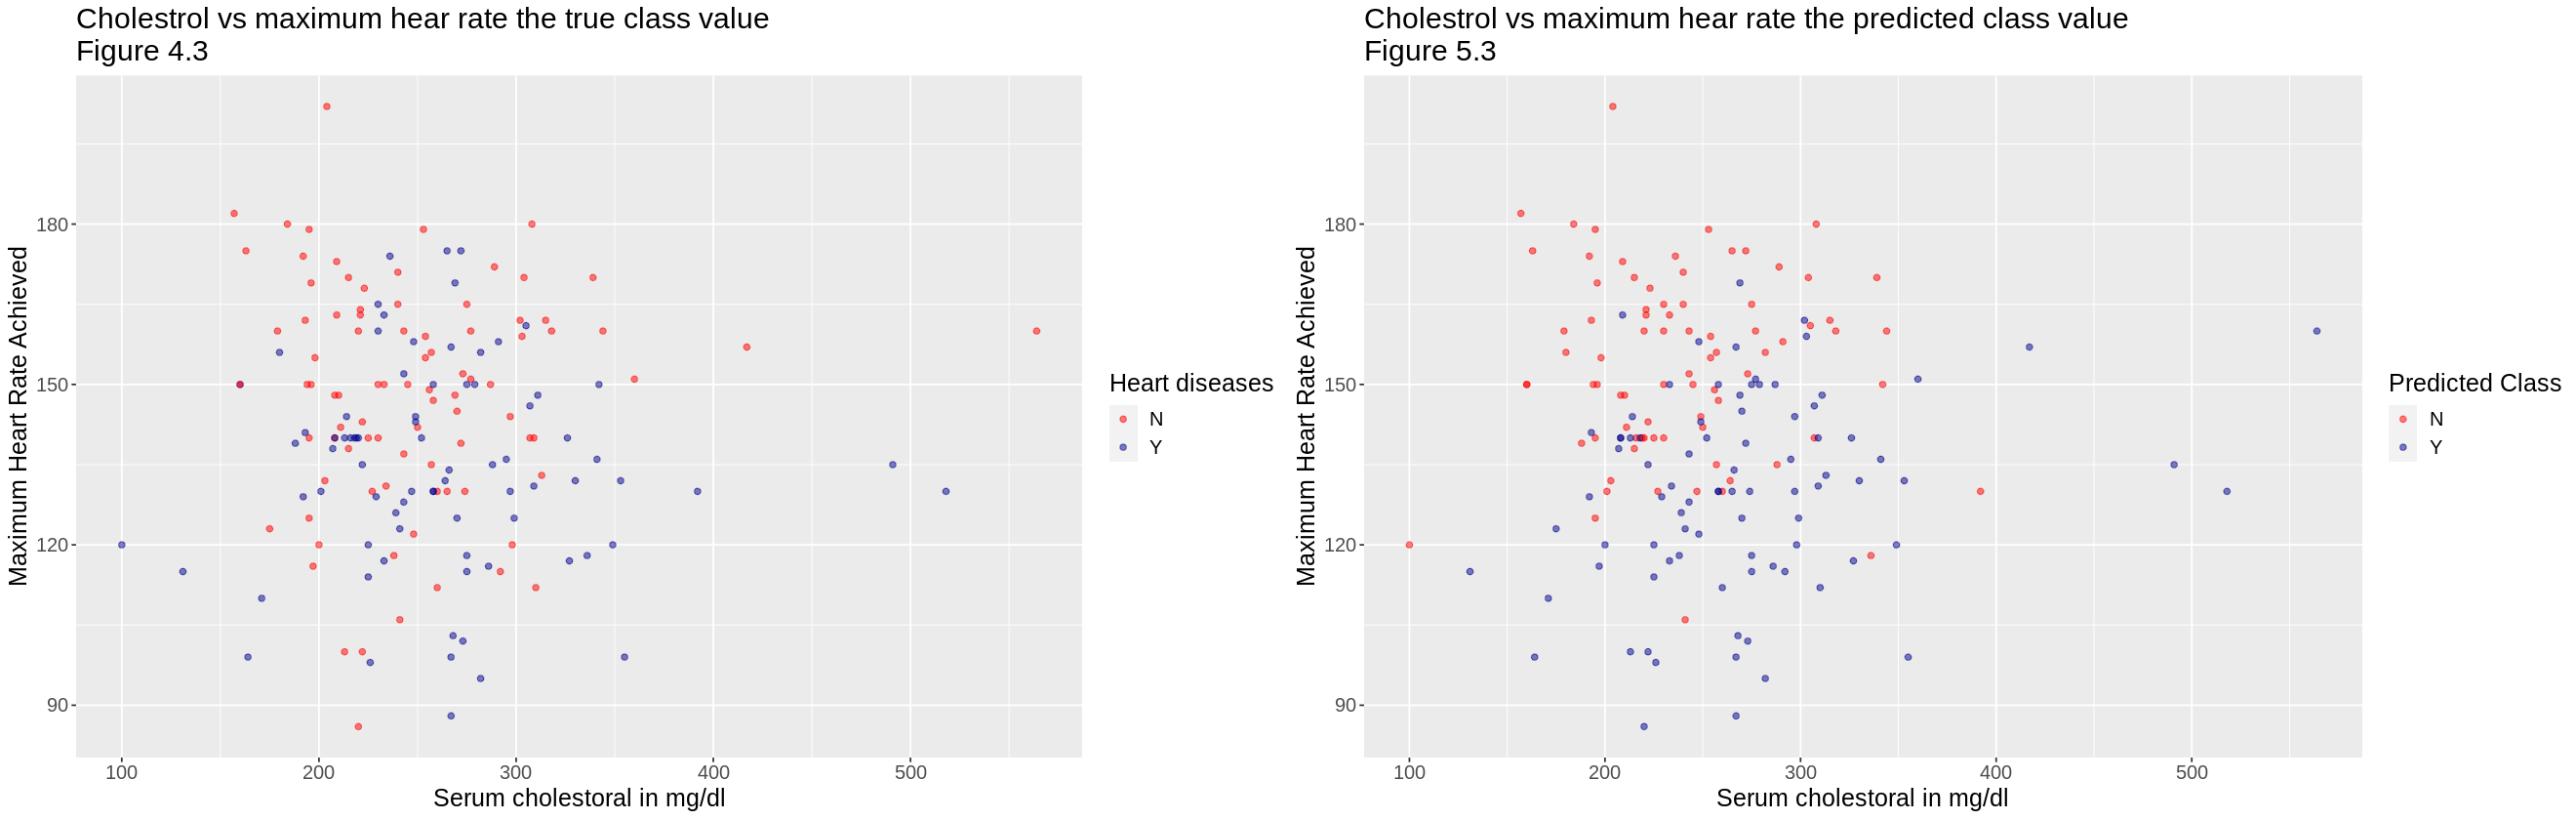

In [20]:
#Visualization
#the actual plot vs the one that we predict
options(repr.plot.height = 7, repr.plot.width=22)


age_chol_true <- heart_data_testing %>% 
    ggplot(aes(x = age, y = chol, colour = heart_disease)) + 
    geom_point(stat = "identity", alpha = 0.5)+ 
    labs(x="Age (in years)", y = "Serum cholestoral in mg/dl", colour = "Heart diseases")+
    theme (text = element_text (size = 15)) +
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Age vs chol the true class value
Figure 4.1")


age_chol_pred <- heart_test_predictions %>% 
    ggplot(aes(x = age, y = chol, color = .pred_class)) + 
    geom_point(stat = "identity", alpha = 0.5)+ 
    labs(x="Age (in years)", y = "Serum cholestoral in mg/dl", colour = "Predicted Class")+
    theme (text = element_text (size = 15)) +
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Age vs chol the predicted class value
Figure 5.1")


grid.arrange(age_chol_true, age_chol_pred, nrow=1)

thalach_age_true <- heart_test_predictions %>% 
    ggplot(aes(x = thalach, y = age, color = heart_disease)) + 
    geom_point(stat = "identity", alpha = 0.5)+
    labs(x = "Maximum Heart Rate Achieved", y= "Age (in years)", color = "Heart diseases")+
    theme (text = element_text (size = 15)) +
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Maximum heart rate vs age the true class value
Figure 4.2")

thalach_age_pred <- heart_test_predictions %>% 
    ggplot(aes(x = thalach, y = age, color = .pred_class)) + 
    geom_point(stat = "identity", alpha = 0.5)+
    labs(x = "Maximum Heart Rate Achieved", y= "Age (in years)", color = "Predicted Class")+
    theme (text = element_text (size = 15))+
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Maximum heart rate vs age the predicted class value
Figure 5.2")

grid.arrange(thalach_age_true, thalach_age_pred, nrow=1)

chol_thalach_true<- heart_test_predictions %>% 
    ggplot(aes(x = chol, y = thalach , color = heart_disease)) + 
    geom_point(stat = "identity", alpha = 0.5)+
    labs(x = "Serum cholestoral in mg/dl" , y= "Maximum Heart Rate Achieved", color = "Heart diseases")+
    theme (text = element_text (size = 15))+
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Cholestrol vs maximum hear rate the true class value
Figure 4.3")

chol_thalach_pred <- heart_test_predictions %>% 
    ggplot(aes(x = chol, y = thalach , color = .pred_class)) + 
    geom_point(stat = "identity", alpha = 0.5)+
    labs(x = "Serum cholestoral in mg/dl" , y= "Maximum Heart Rate Achieved", color = "Predicted Class")+
    theme (text = element_text (size = 15)) +
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Cholestrol vs maximum hear rate the predicted class value
Figure 5.3")

grid.arrange(chol_thalach_true, chol_thalach_pred, nrow=1)

## Discussion 

1. We were expecting to find that people with higher age, greater Serum cholesterol, and lower maximum heart rate would be more likely to have heart disease; our final plots clearly reinforce those expectations. More specifically, we can observe that our model predicts that people older than 50, who have a maximum heart rate of lower than 150 and Serum cholesterol greater than 200 mg/d are having heart disease.

2. The accuracy of our model is about 65%. The confusion matrix also shows 54 observations were correctly predicted as heart disease, and 58 were correctly predicted as no heart disease. Therefore the classifier labeled 54 + 56 = 110 observations correctly. It also shows that the classifier made some mistakes; in particular, it classified 25 observations as no heart disease when they were truly heart disease and 32 observations as heart disease when they were truly no heart disease. While these results might not seem impressive, we have to consider that it is very hard to predict heart disease(Rawat, Shubhankar. “Heart Disease Prediction.”) Moreover, we are only using accessible information, and we are predicting most of the "Yes" cases, which is very valuable because early detection and treatment results in a reduction of the severity and mortality of heart disease. Furthermore, we can conclude from our results that great cholesterol and low heart rate are two causes of heart disease. Both of these factors can be prevented with special care and consultation of a doctor. 

3. These findings open up many other important questions. Instead of predicting whether someone has heart disease or not, we can move over to predict the possibility of the person having heart disease. This will be much better at reducing mortality as even if the person does not have heart disease, we can see if they are at high risk for the disease and treat accordingly. Another future question is why the suggested factors, cholesterol and maximum heart rate, are causes of heart disease. In our projecty, we established the correlation between factors such as age, cholestrol and heart rate with heart disease, but we propose that the causaul relationship between the predictors and the target variable should be explored to help us find precautions that potentially lead to a significant reduction of heart disease.

## Citations

1. UCI Machine Learning Repository: Data Set, [https://archive.ics.uci.edu/ml/datasets/Heart+Disease](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).
2. “Heart Health and Aging.” National Institute on Aging, U.S. Department of Health and Human Services, [https://www.nia.nih.gov/health/heart-health-and-aging](https://www.nia.nih.gov/health/heart-health-and-aging).
3. “Cholesterol and Heart Disease.” WebMD, WebMD, [https://www.webmd.com/heart-disease/guide/heart-disease-lower-cholesterol-risk](https://www.webmd.com/heart-disease/guide/heart-disease-lower-cholesterol-risk).
4. “Understanding Your Target Heart Rate.” Johns Hopkins Medicine, [https://www.hopkinsmedicine.org/health/wellness-and-prevention/understanding-your-target-heart-rate](https://www.hopkinsmedicine.org/health/wellness-and-prevention/understanding-your-target-heart-rate).
5. Rawat, Shubhankar. “Heart Disease Prediction.” Medium, Towards Data Science, 28 June 2021, https://towardsdatascience.com/heart-disease-prediction-73468d630cfc. 